In [1]:
# !pip install -qU tensorflow-addons livelossplot

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)

In [4]:
from dataclasses import dataclass

@dataclass
class DataConfig:
    IMAGE_SIZE = 32
    PATCH_SIZE = 8
    N_CLASSES = 10

@dataclass
class ModelConfig:
    EMBEDDING_DIM =  256
    NUM_HEADS = 8
    DEPTH =  6
    MLP_RATIO = 2.0

    LINEAR_DROP = 0.2
    ATTENTION_DROP = 0.0

@dataclass
class TrainingConfig:
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 256
    NUM_EPOCHS = 20
    WEIGHT_DECAY = 0.001

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(DataConfig.IMAGE_SIZE, DataConfig.IMAGE_SIZE),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [7]:
from vision_transformer import VisionTransformer

In [8]:
vit_model = VisionTransformer(
    img_size=DataConfig.IMAGE_SIZE,
    patch_size=DataConfig.PATCH_SIZE,
    n_classes=DataConfig.N_CLASSES,
    embedding_dim=ModelConfig.EMBEDDING_DIM,
    depth=ModelConfig.DEPTH,
    num_heads=ModelConfig.NUM_HEADS,
    mlp_ratio=ModelConfig.MLP_RATIO,
    linear_drop=ModelConfig.LINEAR_DROP,
    attention_drop=ModelConfig.ATTENTION_DROP,
)

In [9]:
optimizer_fn = tfa.optimizers.AdamW(learning_rate=TrainingConfig.LEARNING_RATE, weight_decay=TrainingConfig.WEIGHT_DECAY)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ]

In [10]:
def create_model(input_shape):        
    inputs = tf.keras.layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    output = vit_model(augmented)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [11]:
checkpoint_filepath = r'/content/checkpoints/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
model = create_model(input_shape=(DataConfig.IMAGE_SIZE, DataConfig.IMAGE_SIZE, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 32, 32, 3)        7         
 al)                                                             
                                                                 
 vision_transformer (VisionT  (None, 10)               3219722   
 ransformer)                                                     
                                                                 
Total params: 3,219,729
Trainable params: 3,219,722
Non-trainable params: 7
_________________________________________________________________


In [13]:
model.compile(
    optimizer=optimizer_fn,
    loss=loss_fn,
    metrics=metrics,
)

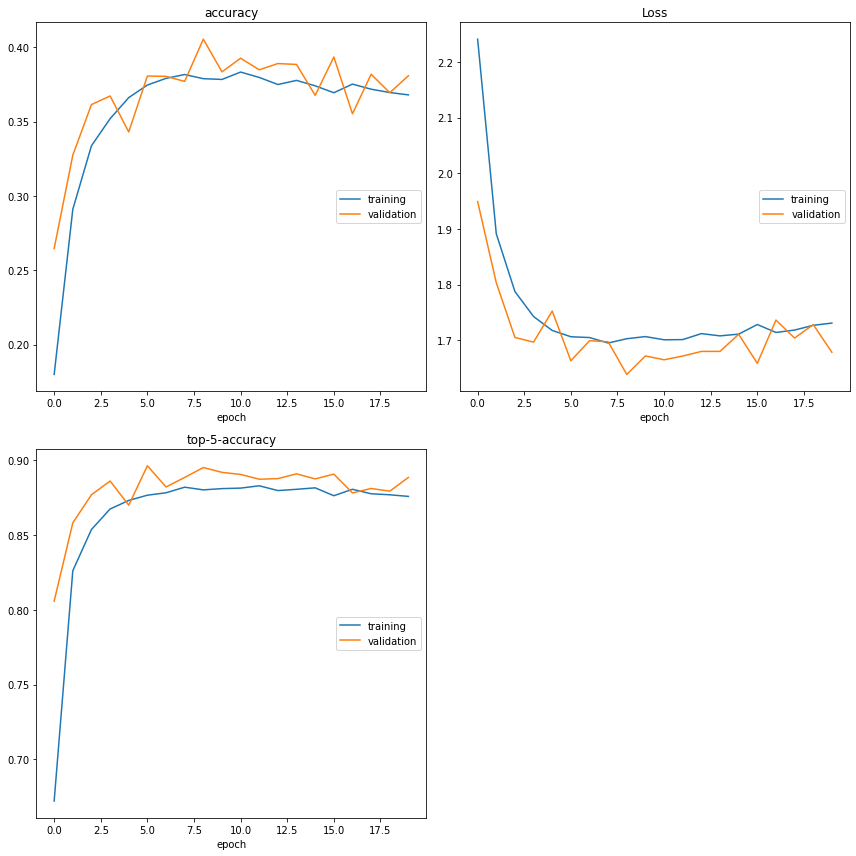

accuracy
	training         	 (min:    0.180, max:    0.383, cur:    0.368)
	validation       	 (min:    0.265, max:    0.405, cur:    0.381)
Loss
	training         	 (min:    1.695, max:    2.241, cur:    1.731)
	validation       	 (min:    1.639, max:    1.949, cur:    1.678)
top-5-accuracy
	training         	 (min:    0.672, max:    0.883, cur:    0.876)
	validation       	 (min:    0.806, max:    0.896, cur:    0.889)
176/176 [==============================] - 15s 88ms/step - loss: 1.7309 - accuracy: 0.3679 - top-5-accuracy: 0.8759 - val_loss: 1.6783 - val_accuracy: 0.3808 - val_top-5-accuracy: 0.8886


In [14]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=TrainingConfig.BATCH_SIZE,
        epochs=TrainingConfig.NUM_EPOCHS,
        validation_split=0.1,
        callbacks=[model_checkpoint_callback, PlotLossesKeras()],
    )